In [1]:
# Load packages and check versions
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 #high res figures
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import shap
import pickle

print('The Python version is {}.\n'.format(sys.version))
print('The Numpy version is {}.\n'.format(np.__version__))
print('The Pandas version is {}.\n'.format(pd.__version__))
print('The Scipy version is {}.\n'.format(scipy.__version__))
print('The Matplotlib version is {}.\n'.format(mpl.__version__))
print('The Scikit-Learn version is {}.\n'.format(sklearn.__version__))
print('The XGBoost version is {}.\n'.format(xgb.__version__))
print('The SHAP version is {}.\n'.format(shap.__version__))
# The Python version is 3.8.2 (default, Mar 26 2020, 10:43:30) 
# [Clang 4.0.1 (tags/RELEASE_401/final)].

# The Numpy version is 1.19.2.

# The Pandas version is 1.2.1.

# The Scipy version is 1.6.1.

# The Matplotlib version is 3.3.2.

# The Scikit-Learn version is 0.23.2.

# The XGBoost version is 1.3.0.

# The SHAP version is 0.37.0.

The Python version is 3.8.2 (default, Mar 26 2020, 10:43:30) 
[Clang 4.0.1 (tags/RELEASE_401/final)].

The Numpy version is 1.19.2.

The Pandas version is 1.2.1.

The Scipy version is 1.6.1.

The Matplotlib version is 3.3.2.

The Scikit-Learn version is 0.23.2.

The XGBoost version is 1.3.0.

The SHAP version is 0.37.0.



Make synthetic data

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=5000, n_features=40, n_informative=3,
    n_redundant=2, n_repeated=0, n_classes=2,
    n_clusters_per_class=3, weights=None, flip_y=0.05,
    class_sep=0.1, hypercube=True, shift=0.0,
    scale=1.0, shuffle=True, random_state=2)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
train_test_split(X, y, test_size=0.2, random_state=24)

In [4]:
y.mean()

0.4986

# Early stopping

In [5]:
xgb_model_1 = xgb.XGBClassifier(
    n_estimators=1000,
    verbosity=1,
    use_label_encoder=False,
    objective='binary:logistic',
    learning_rate=0.3)

In [6]:
%%time
xgb_model_1.fit(X_train, y_train, eval_metric="auc", verbose=True)

CPU times: user 42.3 s, sys: 189 ms, total: 42.4 s
Wall time: 11.1 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

In [7]:
val_set_pred_proba = xgb_model_1.predict_proba(X_val)[:,1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, val_set_pred_proba)
#0.7773798710782294

0.7773798710782294

Now with early stopping.

In [8]:
eval_set = [(X_train, y_train), (X_val, y_val)]

In [9]:
%%time
xgb_model_1.fit(X_train, y_train, eval_set=eval_set,
                eval_metric='auc',
                verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.80412	validation_1-auc:0.75223
[1]	validation_0-auc:0.84422	validation_1-auc:0.79207
[2]	validation_0-auc:0.85920	validation_1-auc:0.79278
[3]	validation_0-auc:0.86616	validation_1-auc:0.79517
[4]	validation_0-auc:0.88261	validation_1-auc:0.79659
[5]	validation_0-auc:0.88605	validation_1-auc:0.80061
[6]	validation_0-auc:0.89226	validation_1-auc:0.80224
[7]	validation_0-auc:0.89826	validation_1-auc:0.80305
[8]	validation_0-auc:0.90559	validation_1-auc:0.80095
[9]	validation_0-auc:0.91954	validation_1-auc:0.79685
[10]	validation_0-auc:0.92113	validation_1-auc:0.79608
[11]	validation_0-auc:0.92393	validation_1-auc:0.79763
[12]	validation_0-auc:0.92526	validation_1-auc:0.79842
[13]	validation_0-auc:0.92699	validation_1-auc:0.79883
[14]	validation_0-auc:0.93105	validation_1-auc:0.79716
[15]	validation_0-auc:0.94393	validation_1-auc:0.79750
[16]	validation_0-auc:0.95007	validation_1-auc:0.79431
[17]	validation_0-auc:0.95204	validation_1-auc:0.79407
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

In [10]:
xgb_model_1.get_booster().attributes()

{'best_iteration': '7', 'best_score': '0.80305'}

In [11]:
val_set_pred_proba_2 = xgb_model_1.predict_proba(X_val)[:,1]
roc_auc_score(y_val, val_set_pred_proba_2)
#0.8030501882609966

0.8030501882609966

In [12]:
int(xgb_model_1.get_booster().attributes()['best_iteration'])#()#feature_names

7

This is a simple and intuitive way to reduce overfitting.

# Tuning the learning rate

In [13]:
learning_rates = np.linspace(start=0.01, stop=1, num=25)
learning_rates

array([0.01   , 0.05125, 0.0925 , 0.13375, 0.175  , 0.21625, 0.2575 ,
       0.29875, 0.34   , 0.38125, 0.4225 , 0.46375, 0.505  , 0.54625,
       0.5875 , 0.62875, 0.67   , 0.71125, 0.7525 , 0.79375, 0.835  ,
       0.87625, 0.9175 , 0.95875, 1.     ])

In [14]:
%%time
val_aucs = []
best_iters = []
for learning_rate in learning_rates:
    #Set learning rate and fit model
    xgb_model_1.set_params(**{'learning_rate':learning_rate})
    xgb_model_1.fit(X_train, y_train, eval_set=eval_set,
                    eval_metric='auc',
                    verbose=False, early_stopping_rounds=30)
    
    #Get validation score
    val_set_pred_proba_2 = xgb_model_1.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba_2))
    
    #Get number of rounds
    best_iters.append(
        int(xgb_model_1.get_booster().attributes()['best_iteration']))

CPU times: user 1min 26s, sys: 383 ms, total: 1min 26s
Wall time: 22.5 s


In [15]:
learning_rate_df = \
pd.DataFrame({'Learning rate':learning_rates,
              'Validation AUC':val_aucs,
              'Best iteration':best_iters})

<AxesSubplot:xlabel='Learning rate'>

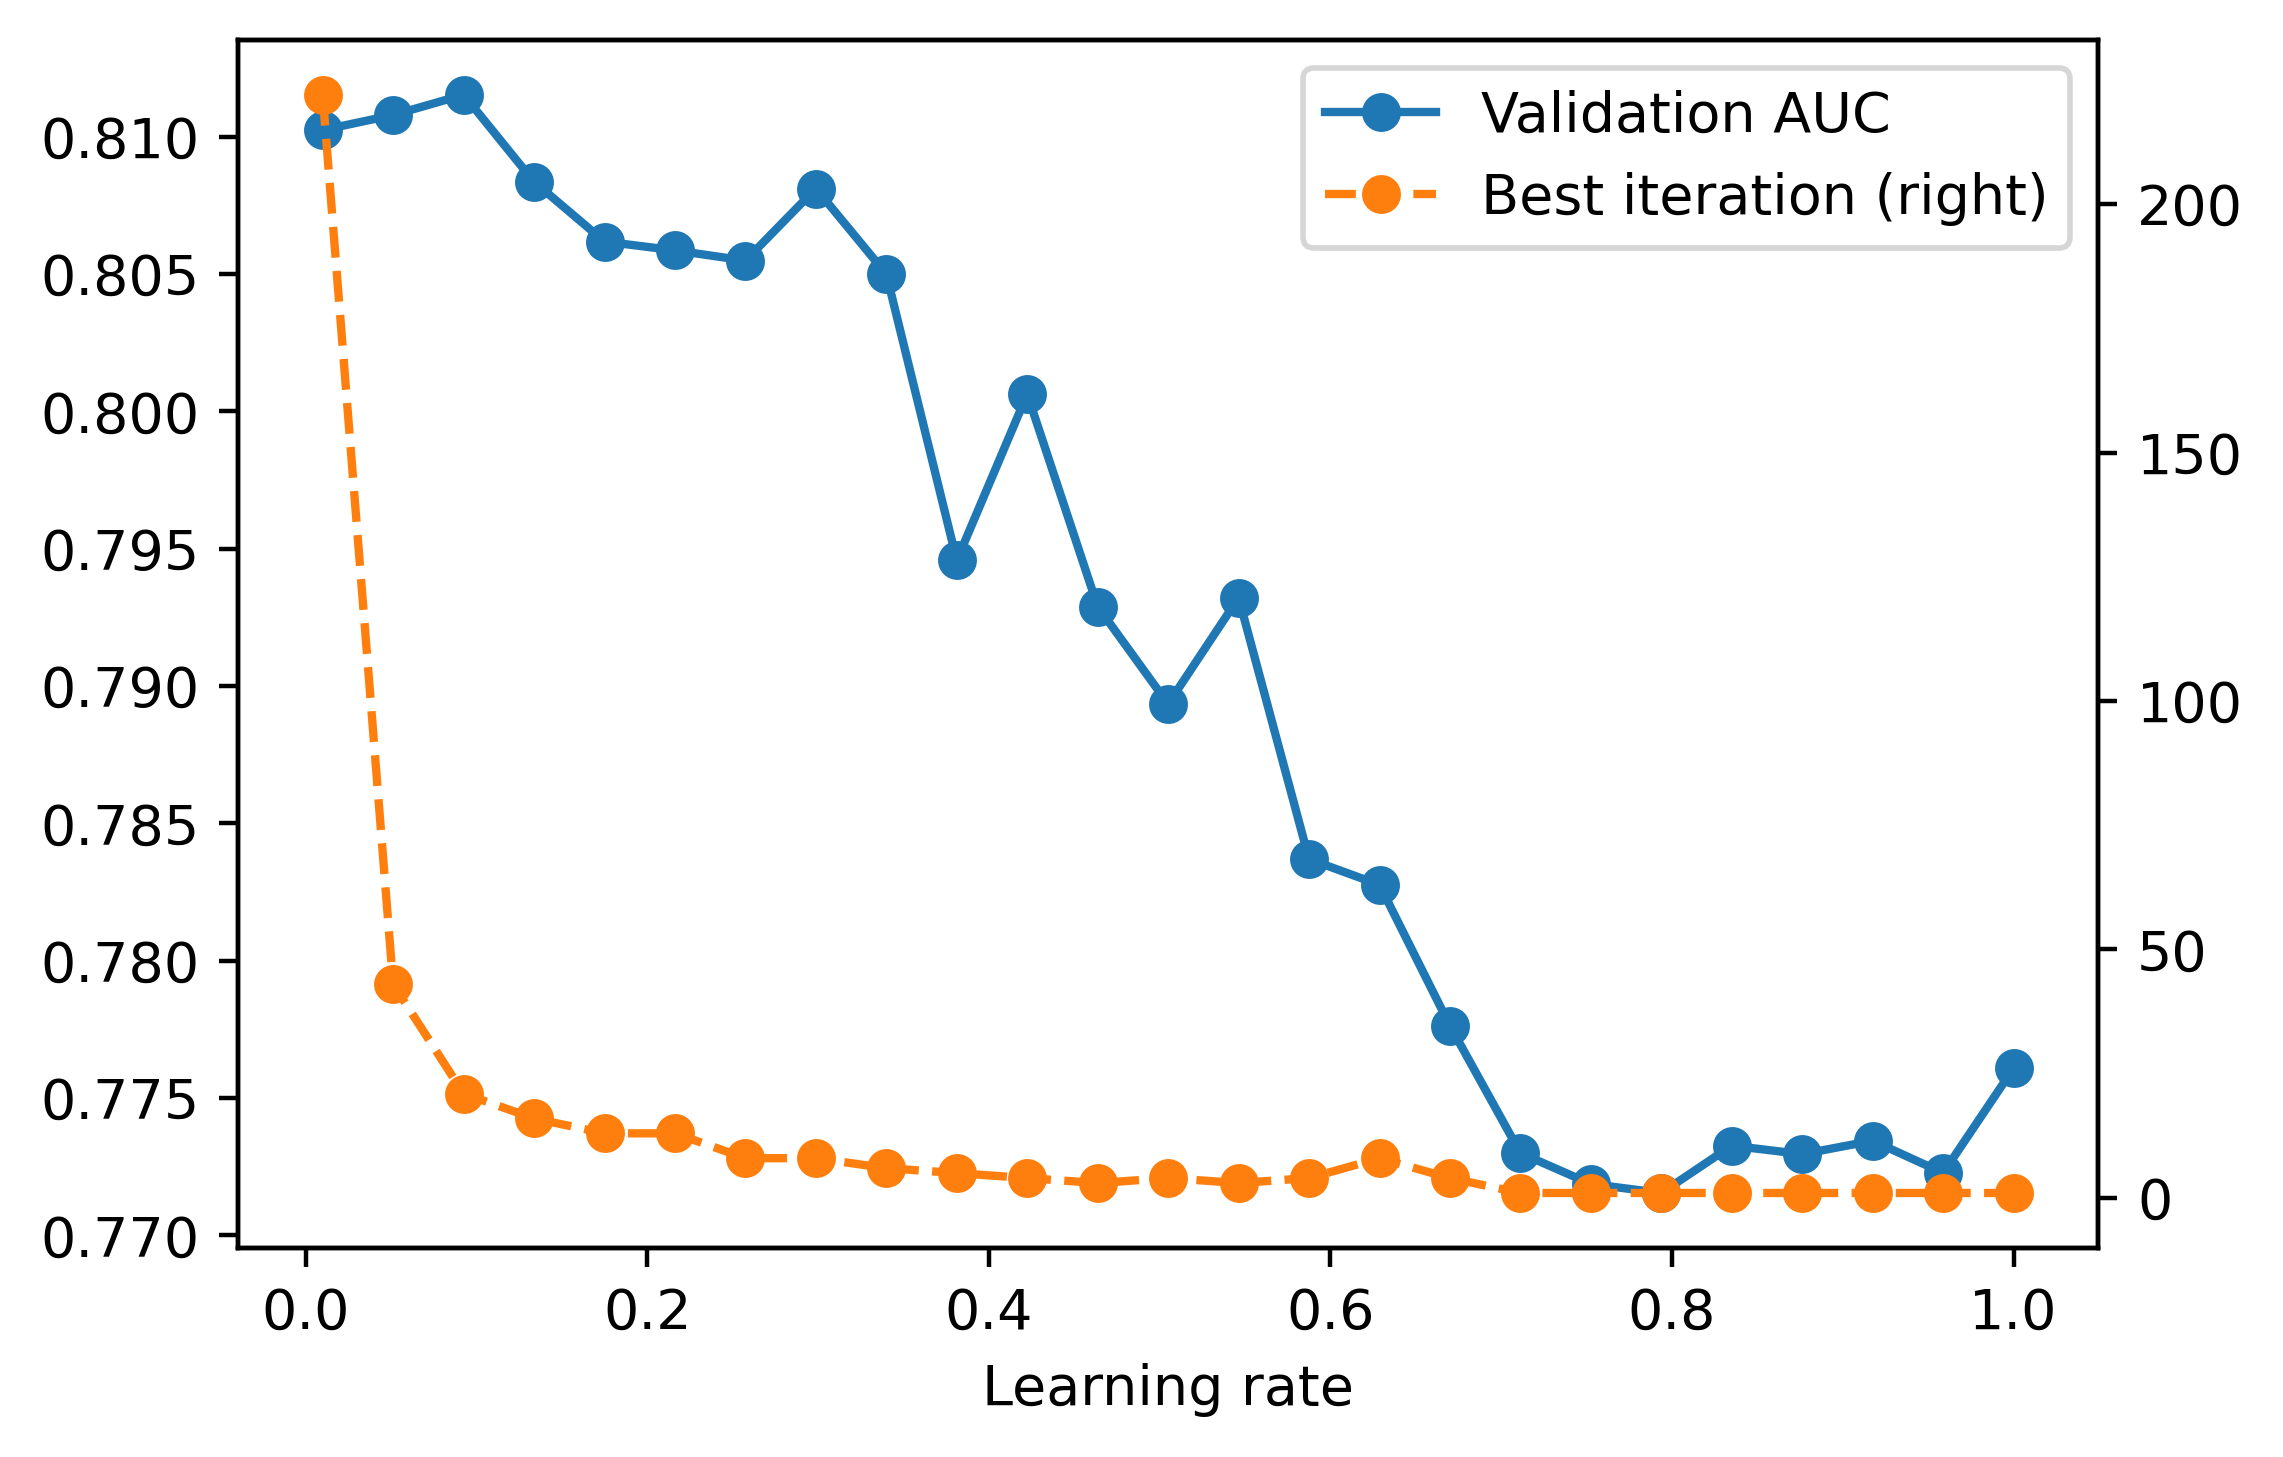

In [16]:
mpl.rcParams['figure.dpi'] = 400
learning_rate_df.set_index('Learning rate')\
.plot(secondary_y='Best iteration', style=['-o', '--o'])

In [17]:
max(val_aucs)
# 0.8115309360232714

0.8115309360232714

# Exercise 22: Tuning XGBoost hyperparameters

In [18]:
from scipy.stats import uniform
param_grid = {'max_depth':[2,3,4,5,6,7],
              'gamma':uniform(loc=0.0, scale=3),
              'min_child_weight':list(range(1,151)),
              'colsample_bytree':uniform(loc=0.1, scale=0.9),
              'subsample':uniform(loc=0.5, scale=0.5),
              'learning_rate':uniform(loc=0.01, scale=0.5)}

In [19]:
from sklearn.model_selection import ParameterSampler
rng = np.random.RandomState(0)
n_iter=1000
param_list = list(ParameterSampler(param_grid, n_iter=n_iter,
                                   random_state=rng))
#n_iter=300

Looks like this is consistent if the seed is set:

In [20]:
param_list[0]

{'colsample_bytree': 0.5939321535345923,
 'gamma': 2.1455680991172583,
 'learning_rate': 0.31138168803582195,
 'max_depth': 5,
 'min_child_weight': 104,
 'subsample': 0.7118273996694524}

In [21]:
xgb_model_2 = xgb.XGBClassifier(
    n_estimators=1000,
    verbosity=1,
    use_label_encoder=False,
    objective='binary:logistic')

In [22]:
xgb_model_2.set_params(**param_list[0])

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5939321535345923,
              gamma=2.1455680991172583, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.31138168803582195,
              max_delta_step=None, max_depth=5, min_child_weight=104,
              missing=nan, monotone_constraints=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.7118273996694524, tree_method=None,
              use_label_encoder=False, validate_parameters=None, verbosity=1)

In [23]:
%%time
val_aucs = []
# train_aucs = []
counter = 1
for params in param_list:
    #Set hyperparameters and fit model
    xgb_model_2.set_params(**params)
    xgb_model_2.fit(X_train, y_train, eval_set=eval_set,
                    eval_metric='auc',
                    verbose=False, early_stopping_rounds=30)
    
    #Get predicted probabilities and save validation ROC AUC
    val_set_pred_proba = xgb_model_2.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba))
    
#     train_set_pred_proba = xgb_model_1.predict_proba(X_train)[:,1]
#     train_aucs.append(roc_auc_score(y_train, train_set_pred_proba))
    
    #Print progress
    if counter % 50 == 0:
        print('Done with {counter} of {n_iter}'.format(
            counter=counter, n_iter=n_iter))
    counter += 1

Done with 50 of 1000
Done with 100 of 1000
Done with 150 of 1000
Done with 200 of 1000
Done with 250 of 1000
Done with 300 of 1000
Done with 350 of 1000
Done with 400 of 1000
Done with 450 of 1000
Done with 500 of 1000
Done with 550 of 1000
Done with 600 of 1000
Done with 650 of 1000
Done with 700 of 1000
Done with 750 of 1000
Done with 800 of 1000
Done with 850 of 1000
Done with 900 of 1000
Done with 950 of 1000
Done with 1000 of 1000
CPU times: user 23min 56s, sys: 11.8 s, total: 24min 8s
Wall time: 6min 12s


In [24]:
xgb_param_search_df = pd.DataFrame(param_list)

In [25]:
xgb_param_search_df.head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample
0,0.593932,2.145568,0.311382,5,104,0.711827
1,0.681305,1.312762,0.455887,2,141,0.691721
2,0.812553,1.586685,0.294022,7,26,0.535518
3,0.178416,0.060655,0.426310,2,83,0.736804
4,0.820820,1.561432,0.349440,2,10,0.768687


In [26]:
# xgb_param_search_df['Training ROC AUC'] = train_aucs
xgb_param_search_df['Validation ROC AUC'] = val_aucs

In [27]:
max_auc = xgb_param_search_df['Validation ROC AUC'].max()
max_auc
# 0.8151220995602575

0.8151220995602575

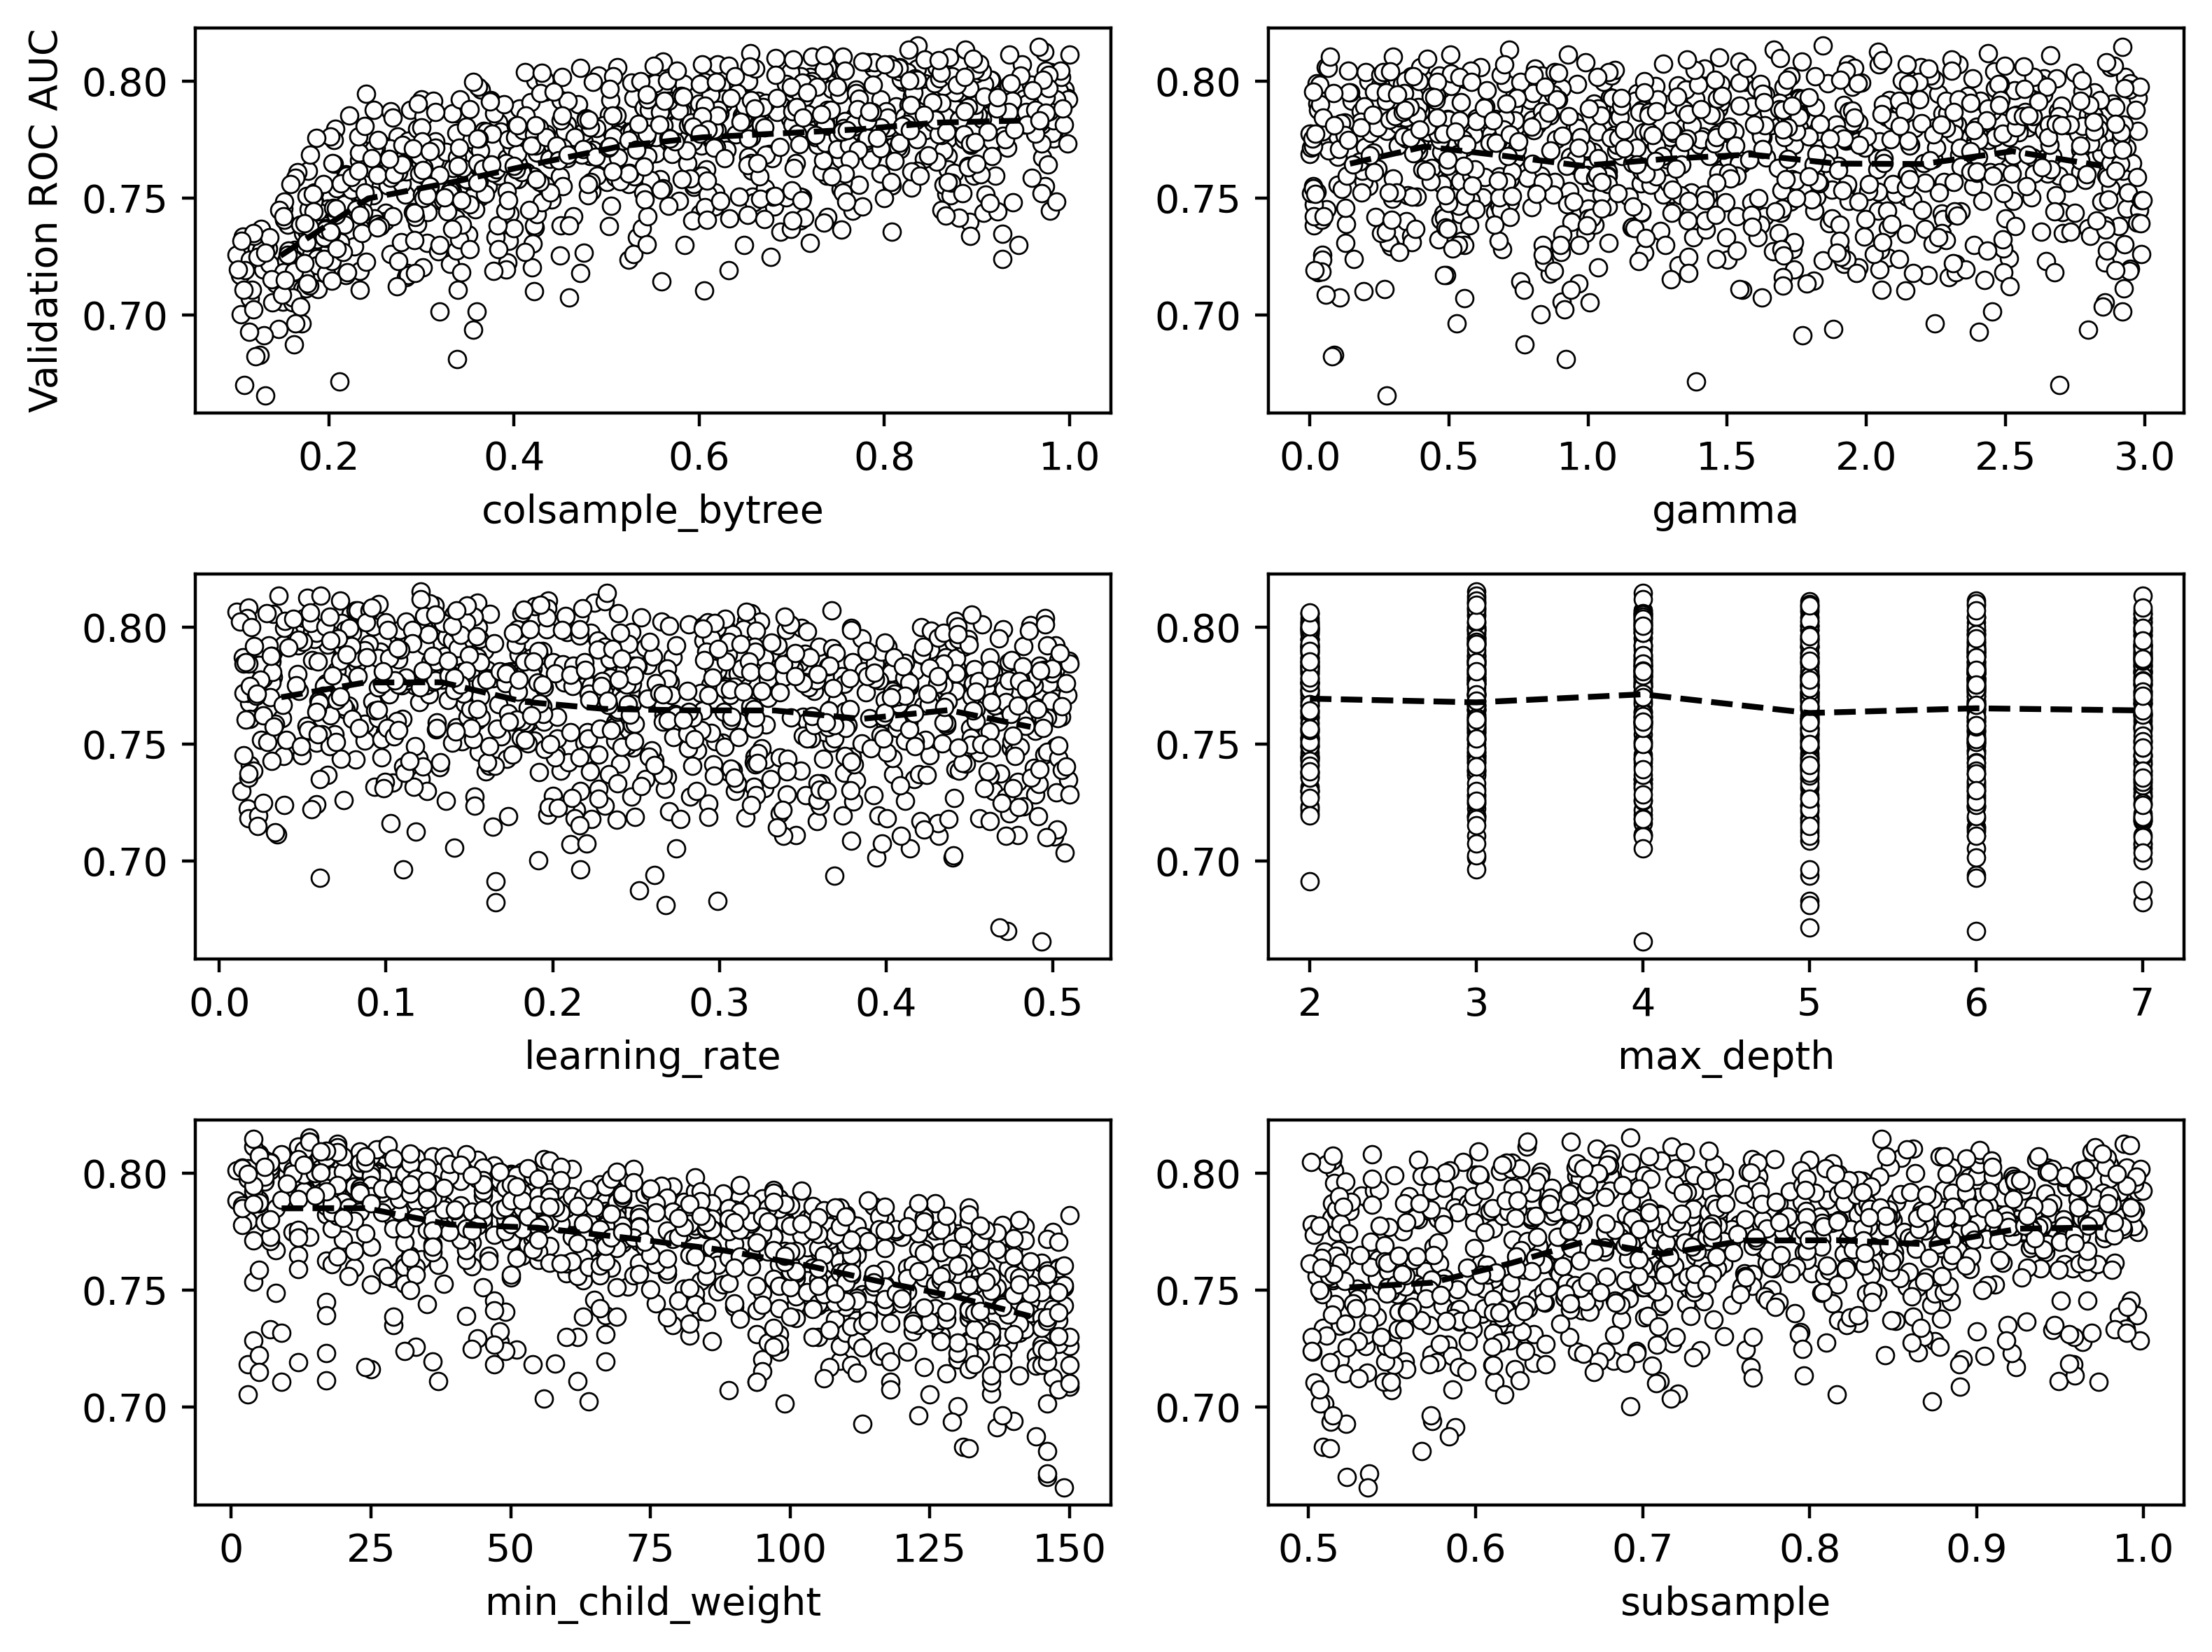

In [28]:
mpl.rcParams['figure.dpi'] = 400
fig, axs = plt.subplots(3,2,figsize=(8,6))
counter = 0
for col in xgb_param_search_df.columns[:-1]:
#     print(col)
    this_ax = axs.flatten()[counter]
    xgb_param_search_df.plot.scatter(
        x=col, y='Validation ROC AUC',
        ax=this_ax, marker='o',
        color='w',
        edgecolor='k',
        linewidth=0.5)
    
    if counter > 0:
        this_ax.set_ylabel('')
    counter += 1
    
    if col != 'max_depth':
        out, bins = pd.qcut(xgb_param_search_df[col], q=10,
                            retbins=True, duplicates='drop')
        half_points = [(bins[ix] + bins[ix+1])/2
                       for ix in range(len(bins)-1)]
    else:
        out = xgb_param_search_df[col]
        half_points = np.sort(xgb_param_search_df[col].unique())
        
    tmp_df = xgb_param_search_df.copy()
    tmp_df['param_decile'] = out
    mean_df = tmp_df.groupby('param_decile').agg(
        {'Validation ROC AUC':'mean'})
    
    this_ax.plot(half_points, mean_df.values, color='k', linestyle='--')
plt.tight_layout()

This is a good illustration of the effects of these hyperparameters, even if there is minimal improvement from tuning them, at least on these synthetic data.

What is the best hyperparameter combination?

In [29]:
max_ix = xgb_param_search_df['Validation ROC AUC'] == max_auc
xgb_param_search_df[max_ix]

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,Validation ROC AUC
308,0.83627,1.843039,0.120745,3,14,0.692646,0.815122


In [30]:
param_list[np.where(max_ix)[0][0]]

{'colsample_bytree': 0.8362695026564751,
 'gamma': 1.8430388999388927,
 'learning_rate': 0.12074508940147886,
 'max_depth': 3,
 'min_child_weight': 14,
 'subsample': 0.6926457795226095}

# `lossguide` tree growing

In [31]:
xgb_model_3 = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=0,
    learning_rate=0.1,
    verbosity=1,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    tree_method='hist',
    grow_policy='lossguide')

In [32]:
max_leaves_values = list(range(5,105,5))
print(max_leaves_values[:5])
print(max_leaves_values[-5:])

[5, 10, 15, 20, 25]
[80, 85, 90, 95, 100]


In [33]:
%%time
val_aucs = []
for max_leaves in max_leaves_values:
    #Set parameter and fit model
    xgb_model_3.set_params(**{'max_leaves':max_leaves})
    xgb_model_3.fit(X_train, y_train, eval_set=eval_set,
                  eval_metric='auc',
                  verbose=False, early_stopping_rounds=30)
    
    #Get validation score
    val_set_pred_proba = xgb_model_3.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba))

CPU times: user 1min 17s, sys: 1.35 s, total: 1min 18s
Wall time: 20.3 s


In [34]:
max_leaves_df = \
pd.DataFrame({'Max leaves':max_leaves_values,
              'Validation AUC':val_aucs})

<AxesSubplot:xlabel='Max leaves'>

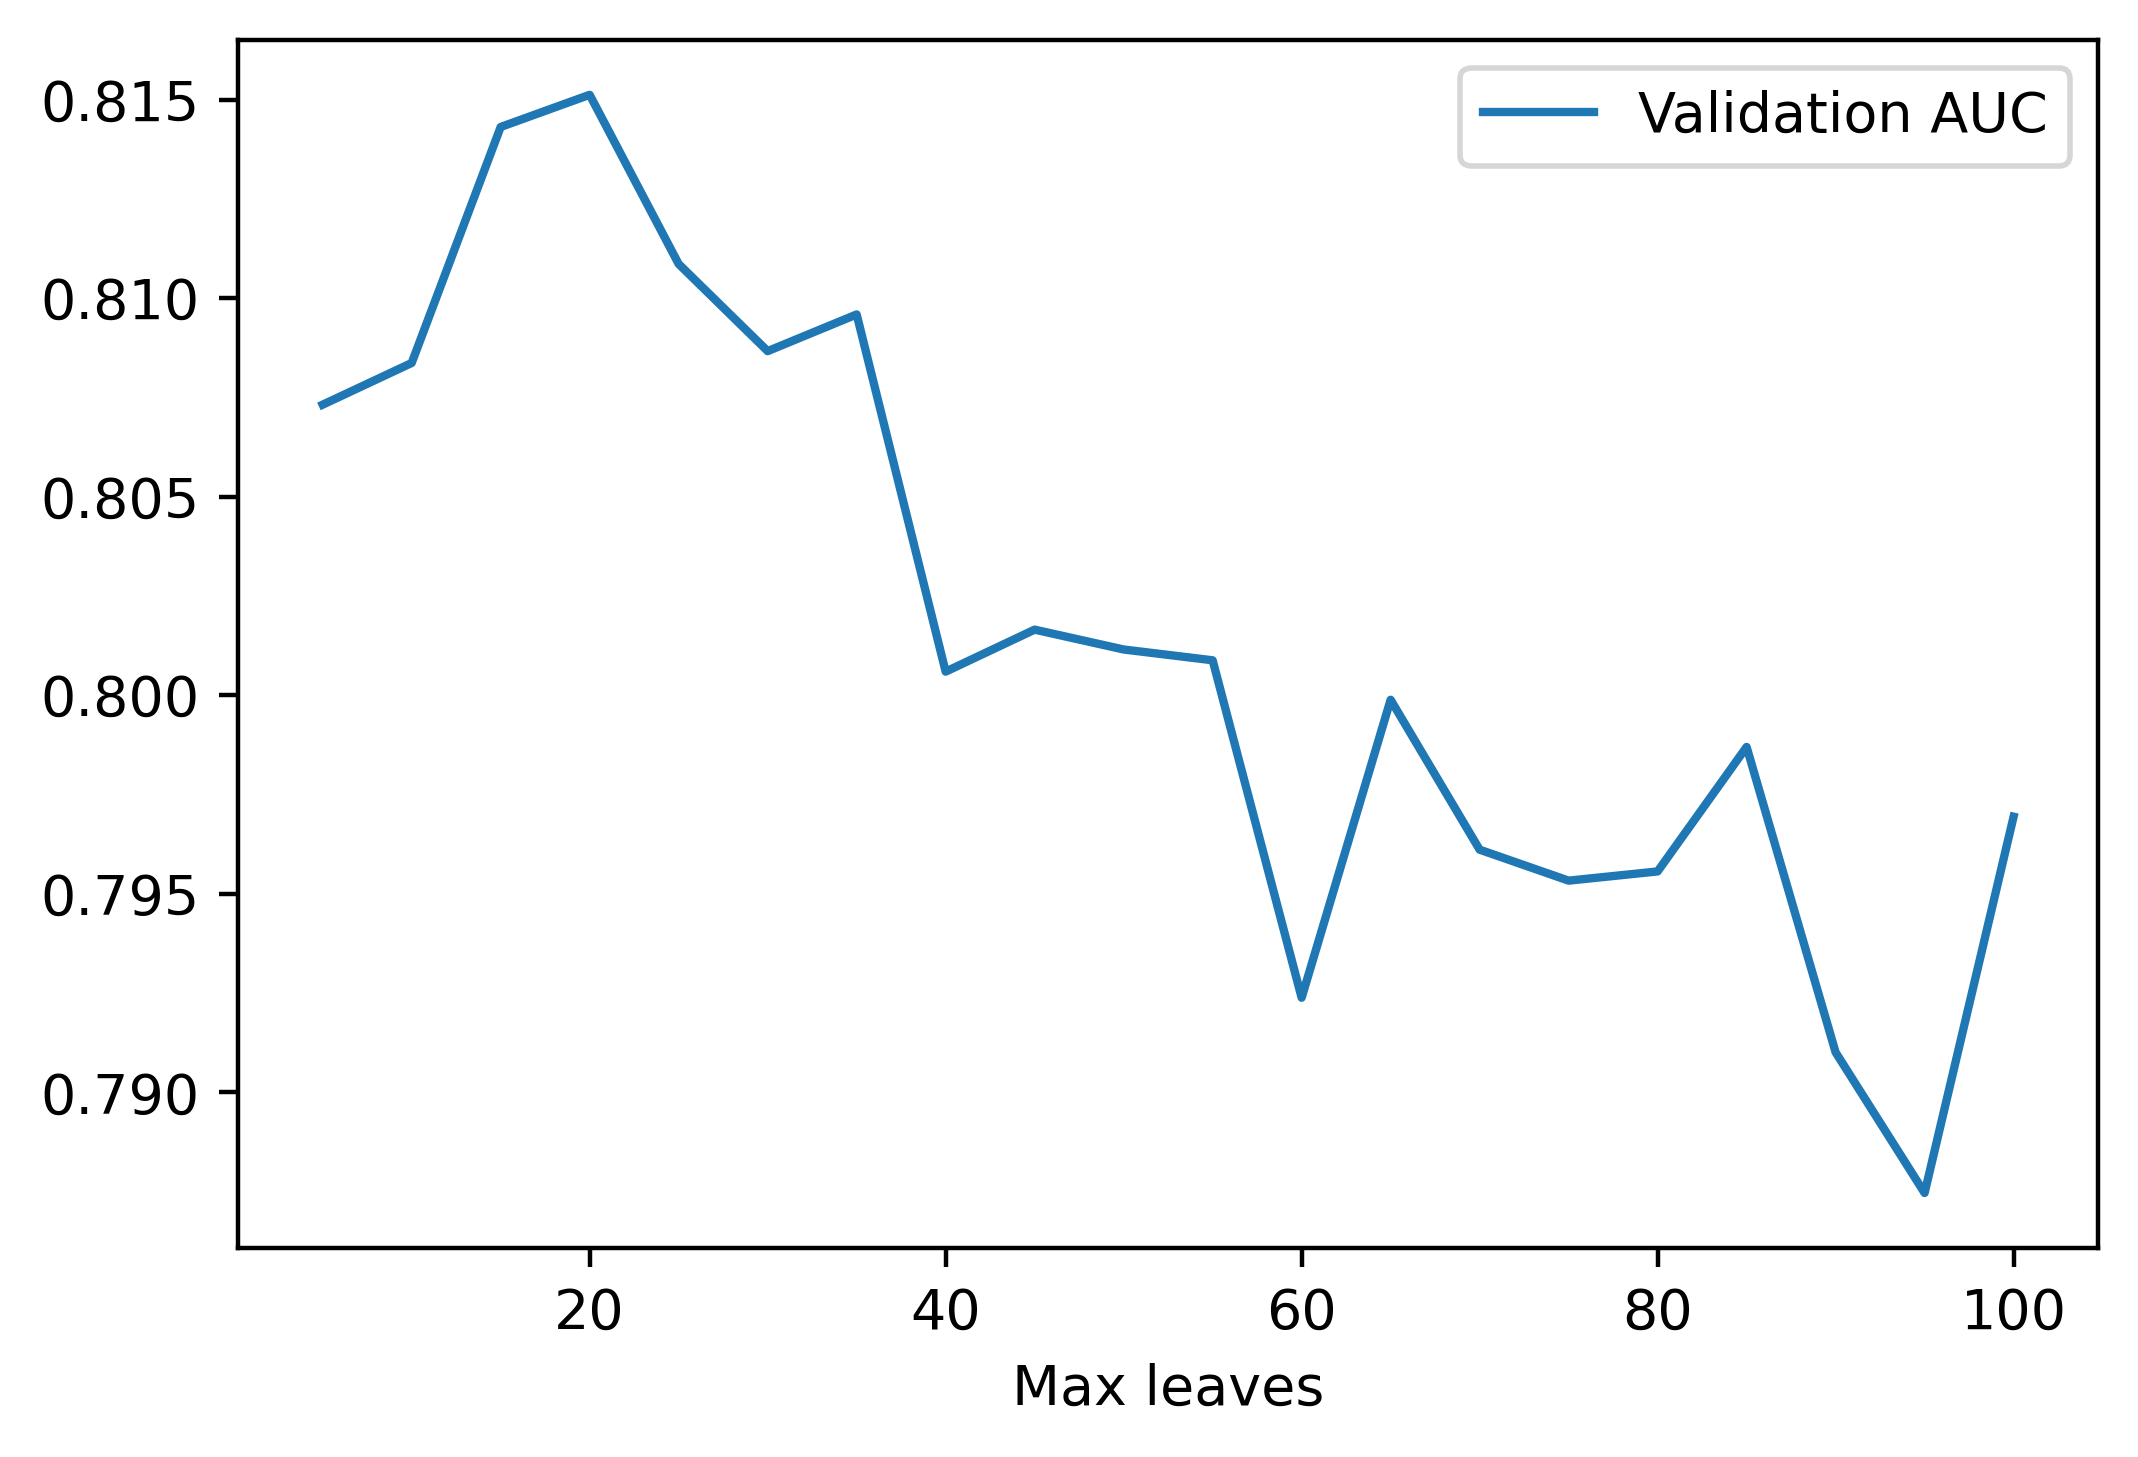

In [35]:
mpl.rcParams['figure.dpi'] = 400
max_leaves_df.set_index('Max leaves').plot()

In [36]:
max_auc = max_leaves_df['Validation AUC'].max()
max_auc
# 0.8151200989120475

0.8151200989120475

In [37]:
max_ix = max_leaves_df['Validation AUC'] == max_auc
max_leaves_df[max_ix]

,Max leaves,Validation AUC
3,20,0.81512


# SHAP values

Train model with optimal max leaves first:

In [38]:
%%time
xgb_model_3.set_params(**{'max_leaves':20})
xgb_model_3.fit(X_train, y_train, eval_set=eval_set,
              eval_metric='auc',
              verbose=False, early_stopping_rounds=30)

CPU times: user 2.12 s, sys: 57.3 ms, total: 2.17 s
Wall time: 631 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=0, max_leaves=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

In [39]:
X_val.shape

(1000, 40)

In [40]:
feature_names = ['Feature {number}'.format(number=number)
                 for number in range(X_val.shape[1])]
X_val_df = pd.DataFrame(data=X_val, columns=feature_names)
X_val_df.head()

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39
0,1.852885,-2.170293,1.057288,0.441873,-0.803131,-0.025139,-0.037143,0.037565,1.163995,0.678410,...,-0.592176,0.529113,0.923351,0.511203,-0.390155,-0.142262,0.760561,-0.421488,1.770300,-0.292780
1,-0.818316,-1.126948,0.647810,0.092433,-1.030356,0.754323,-0.351566,-0.523476,1.144878,0.219172,...,0.545090,1.125089,0.848158,-0.870549,-1.094581,-1.480010,-2.444469,0.905715,-1.008522,1.537315
2,0.020271,-0.758004,-1.136195,0.473366,1.291465,0.890423,-2.217706,-2.030749,1.768624,-2.106202,...,-0.741205,-0.833958,-0.265291,-1.021137,0.247897,-0.058583,0.445473,0.349382,0.208958,0.252826
3,-0.271543,-0.366639,-1.139614,-0.753586,1.427853,1.249856,0.060528,-0.374193,0.047770,0.640638,...,-0.539878,0.569599,0.508334,-0.513756,0.769438,1.100097,0.682759,0.888623,-0.464301,-1.125279
4,-0.549078,0.494648,-1.266778,-0.292728,1.459779,0.497898,-0.618724,-1.225373,0.171507,0.833027,...,-0.366978,-0.308615,0.838910,0.208853,2.517458,0.471553,0.982017,0.030594,0.449982,-0.670582


In [41]:
%time explainer = shap.explainers.Tree(xgb_model_3, data=X_val_df)

CPU times: user 86.6 ms, sys: 7.84 ms, total: 94.5 ms
Wall time: 84.3 ms


In [42]:
%time shap_values = explainer(X_val_df)

CPU times: user 1.26 s, sys: 8.77 ms, total: 1.27 s
Wall time: 1.28 s


In [43]:
shap_values

.values =
array([[-0.00638315,  0.1412218 , -0.03028931, ..., -0.00908076,
        -0.01997885, -0.27901887],
       [ 0.00922845, -0.00938471, -0.05592634, ...,  0.03525513,
         0.01730298,  0.75832271],
       [-0.00094427, -0.0110156 ,  0.03584588, ...,  0.01523119,
        -0.02357144, -0.47479338],
       ...,
       [ 0.00270036, -0.00253366, -0.04025607, ..., -0.0223883 ,
        -0.02611333, -0.30673621],
       [-0.01230153,  0.0095029 , -0.03068384, ...,  0.00167108,
        -0.02014792, -0.07814583],
       [ 0.00766691, -0.01984474,  0.00198599, ..., -0.00086327,
         0.10403682, -0.47275301]])

.base_values =
array([-0.30949622, -0.30949622, -0.30949622, -0.30949622, -0.30949622,
       -0.30949622, -0.30949622, -0.30949622, -0.30949622, -0.30949622,
       -0.30949622, -0.30949622, -0.30949622, -0.30949622, -0.30949622,
       -0.30949622, -0.30949622, -0.30949622, -0.30949622, -0.30949622,
       -0.30949622, -0.30949622, -0.30949622, -0.30949622, -0.30949622,
 

In [44]:
shap_values.values.shape

(1000, 40)

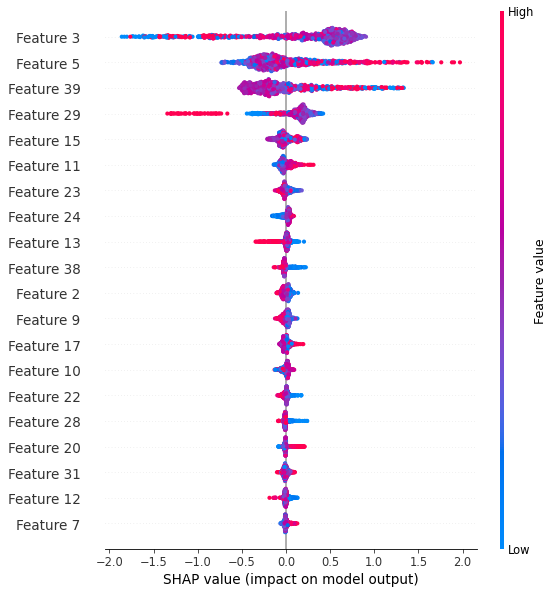

CPU times: user 706 ms, sys: 35.8 ms, total: 742 ms
Wall time: 791 ms


In [45]:
%%time
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values.values, X_val_df)

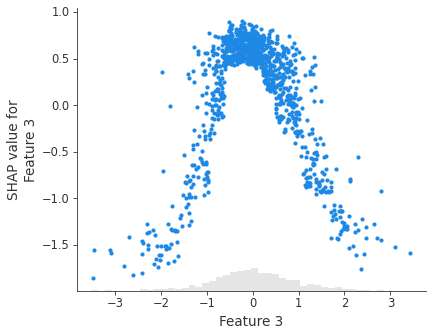

In [46]:
shap.plots.scatter(shap_values[:,'Feature 3'])

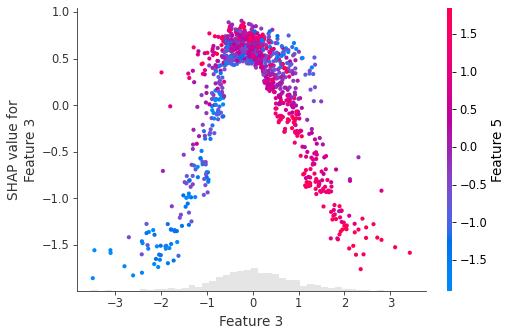

In [47]:
shap.plots.scatter(shap_values[:,'Feature 3'],
                   color=shap_values[:,'Feature 5'])

# Exercise 23

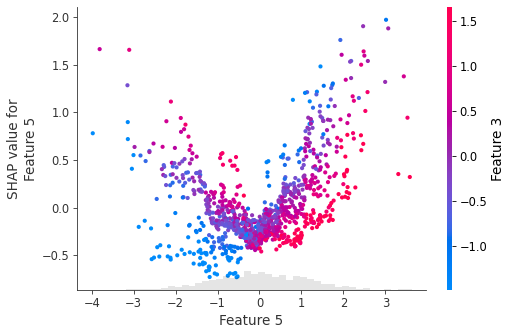

In [48]:
shap.plots.scatter(shap_values[:,'Feature 5'],
                   color=shap_values[:,'Feature 3'])

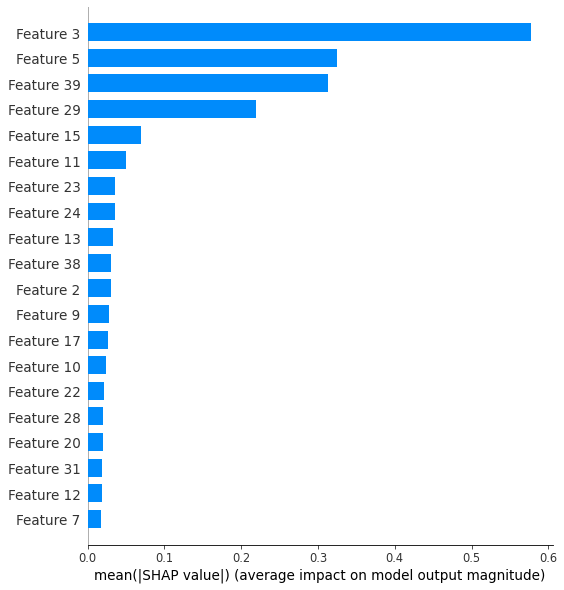

In [49]:
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values.values, X_val, plot_type='bar')

Reconstruct predict probabilities from SHAP values:

In [50]:
shap_values.values.shape

(1000, 40)

In [51]:
explainer.expected_value

-0.30949621941894295

In [52]:
shap_sum = shap_values.values.sum(axis=1) + explainer.expected_value
shap_sum.shape

(1000,)

In [53]:
shap_sum_prob = 1 / (1 + np.exp(-1 * shap_sum))

In [54]:
y_pred_proba = xgb_model_3.predict_proba(X_val)[:,1]
y_pred_proba.shape

(1000,)

In [55]:
df_check = pd.DataFrame(
    {'SHAP sum':shap_sum_prob,
     'Predicted probability':y_pred_proba})
df_check.sample(5, random_state=1)

,SHAP sum,Predicted probability
507,0.497260,0.497260
818,0.466160,0.466160
452,0.881343,0.881343
368,0.145347,0.145347
242,0.481065,0.481065


In [56]:
np.allclose(df_check['SHAP sum'], df_check['Predicted probability'])

True

In [57]:
np.array_equal(df_check['SHAP sum'], df_check['Predicted probability'])

False

<AxesSubplot:xlabel='Predicted probability', ylabel='SHAP sum'>

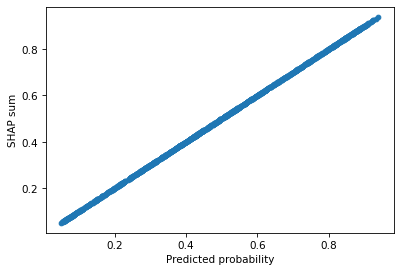

In [58]:
df_check.plot.scatter(x='Predicted probability', y='SHAP sum')

# Activity 6

Load raw case study data

In [59]:
df_orig = pd.read_excel(
    '../../Data/default_of_credit_card_clients__courseware_version_1_21_19.xls')

Repeat previous data cleaning steps: remove samples where all features and the response are zero

In [60]:
df_zero_mask = df_orig == 0
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)
sum(feature_zero_mask)
# 315

315

In [61]:
df_clean = df_orig.loc[~feature_zero_mask,:].copy()
print(df_clean.shape)
# (29685, 25)
print(df_clean['ID'].nunique())
# 29685

(29685, 25)
29685


Repeat previous data cleaning steps: adjust undocumented feature values

In [62]:
df_clean['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True)
df_clean['EDUCATION'].value_counts()
# 2    13884
# 1    10474
# 3     4867
# 4      460
# Name: EDUCATION, dtype: int64

2    13884
1    10474
3     4867
4      460
Name: EDUCATION, dtype: int64

In [63]:
df_clean['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)
df_clean['MARRIAGE'].value_counts()
# 2    15810
# 1    13503
# 3      372
# Name: MARRIAGE, dtype: int64

2    15810
1    13503
3      372
Name: MARRIAGE, dtype: int64

Now instead of throwing away samples with missing data, we fill them with `np.nan` which XGBoost can work with. Start by making a separate dataframe with just these values.

In [64]:
missing_pay_1_mask = df_clean['PAY_1'] == 'Not available'
sum(missing_pay_1_mask)
# 3021

3021

In [65]:
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask,:].copy()
df_missing_pay_1.shape

(3021, 25)

In [66]:
df_missing_pay_1['PAY_1'].head(3)

17    Not available
28    Not available
29    Not available
Name: PAY_1, dtype: object

Load cleaned data that had missing values removed:

In [67]:
df = pd.read_csv('../../Data/Chapter_1_cleaned_data.csv')

In [68]:
features_response = df.columns.tolist()
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                   'PAY_6', 'EDUCATION_CAT', 'graduate school',
                   'high school', 'none', 'others', 'university']
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

Replicate the train/test split from earlier

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(df[features_response[:-1]].values,
                 df['default payment next month'].values,
                 test_size=0.2, random_state=24)

In [70]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# (21331, 17)
# (5333, 17)
# (21331,)
# (5333,)

(21331, 17)
(5333, 17)
(21331,)
(5333,)


In [71]:
df_missing_pay_1.shape

(3021, 25)

Make a similar train/test split with the dataframe that has only missing values, after changing `'Not available'` to `np.nan`. Then combine the non-missing and missing data for the training and testing data sets.

In [72]:
#Copy the data frame with missing PAY_1 and assign imputed values
df_fill_pay_1_filled = df_missing_pay_1.copy()
df_fill_pay_1_filled['PAY_1'] = np.nan

#Split imputed data in to training and testing, using the same
#80/20 split we have used for the data with non-missing PAY_1
X_fill_pay_1_train, X_fill_pay_1_test,\
y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_filled[features_response[:-1]],
    df_fill_pay_1_filled['default payment next month'],
test_size=0.2, random_state=24)

#Concatenate the imputed data with the array of non-missing data
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

Define a validation set to train XGBoost with early stopping.

In [73]:
from sklearn.model_selection import train_test_split
X_train_2, X_val_2, y_train_2, y_val_2 = \
train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=24)

In [74]:
xgb_model_4 = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=0,
    learning_rate=0.1,
    verbosity=1,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    tree_method='hist',
    grow_policy='lossguide')

In [75]:
max_leaves_values = list(range(5,205,5))
print(max_leaves_values[:5])
print(max_leaves_values[-5:])

[5, 10, 15, 20, 25]
[180, 185, 190, 195, 200]


In [76]:
eval_set_2 = [(X_train_2, y_train_2), (X_val_2, y_val_2)]

In [77]:
%%time
val_aucs = []
for max_leaves in max_leaves_values:
    #Set parameter and fit model
    xgb_model_4.set_params(**{'max_leaves':max_leaves})
    xgb_model_4.fit(X_train_2, y_train_2, eval_set=eval_set_2,
                  eval_metric='auc',
                  verbose=False, early_stopping_rounds=30)
    
    #Get validation score
    val_set_pred_proba = xgb_model_4.predict_proba(X_val_2)[:,1]
    val_aucs.append(roc_auc_score(y_val_2, val_set_pred_proba))

CPU times: user 3min 7s, sys: 3.05 s, total: 3min 10s
Wall time: 49 s


In [78]:
max_leaves_df_2 = \
pd.DataFrame({'Max leaves':max_leaves_values,
              'Validation AUC':val_aucs})

<AxesSubplot:xlabel='Max leaves'>

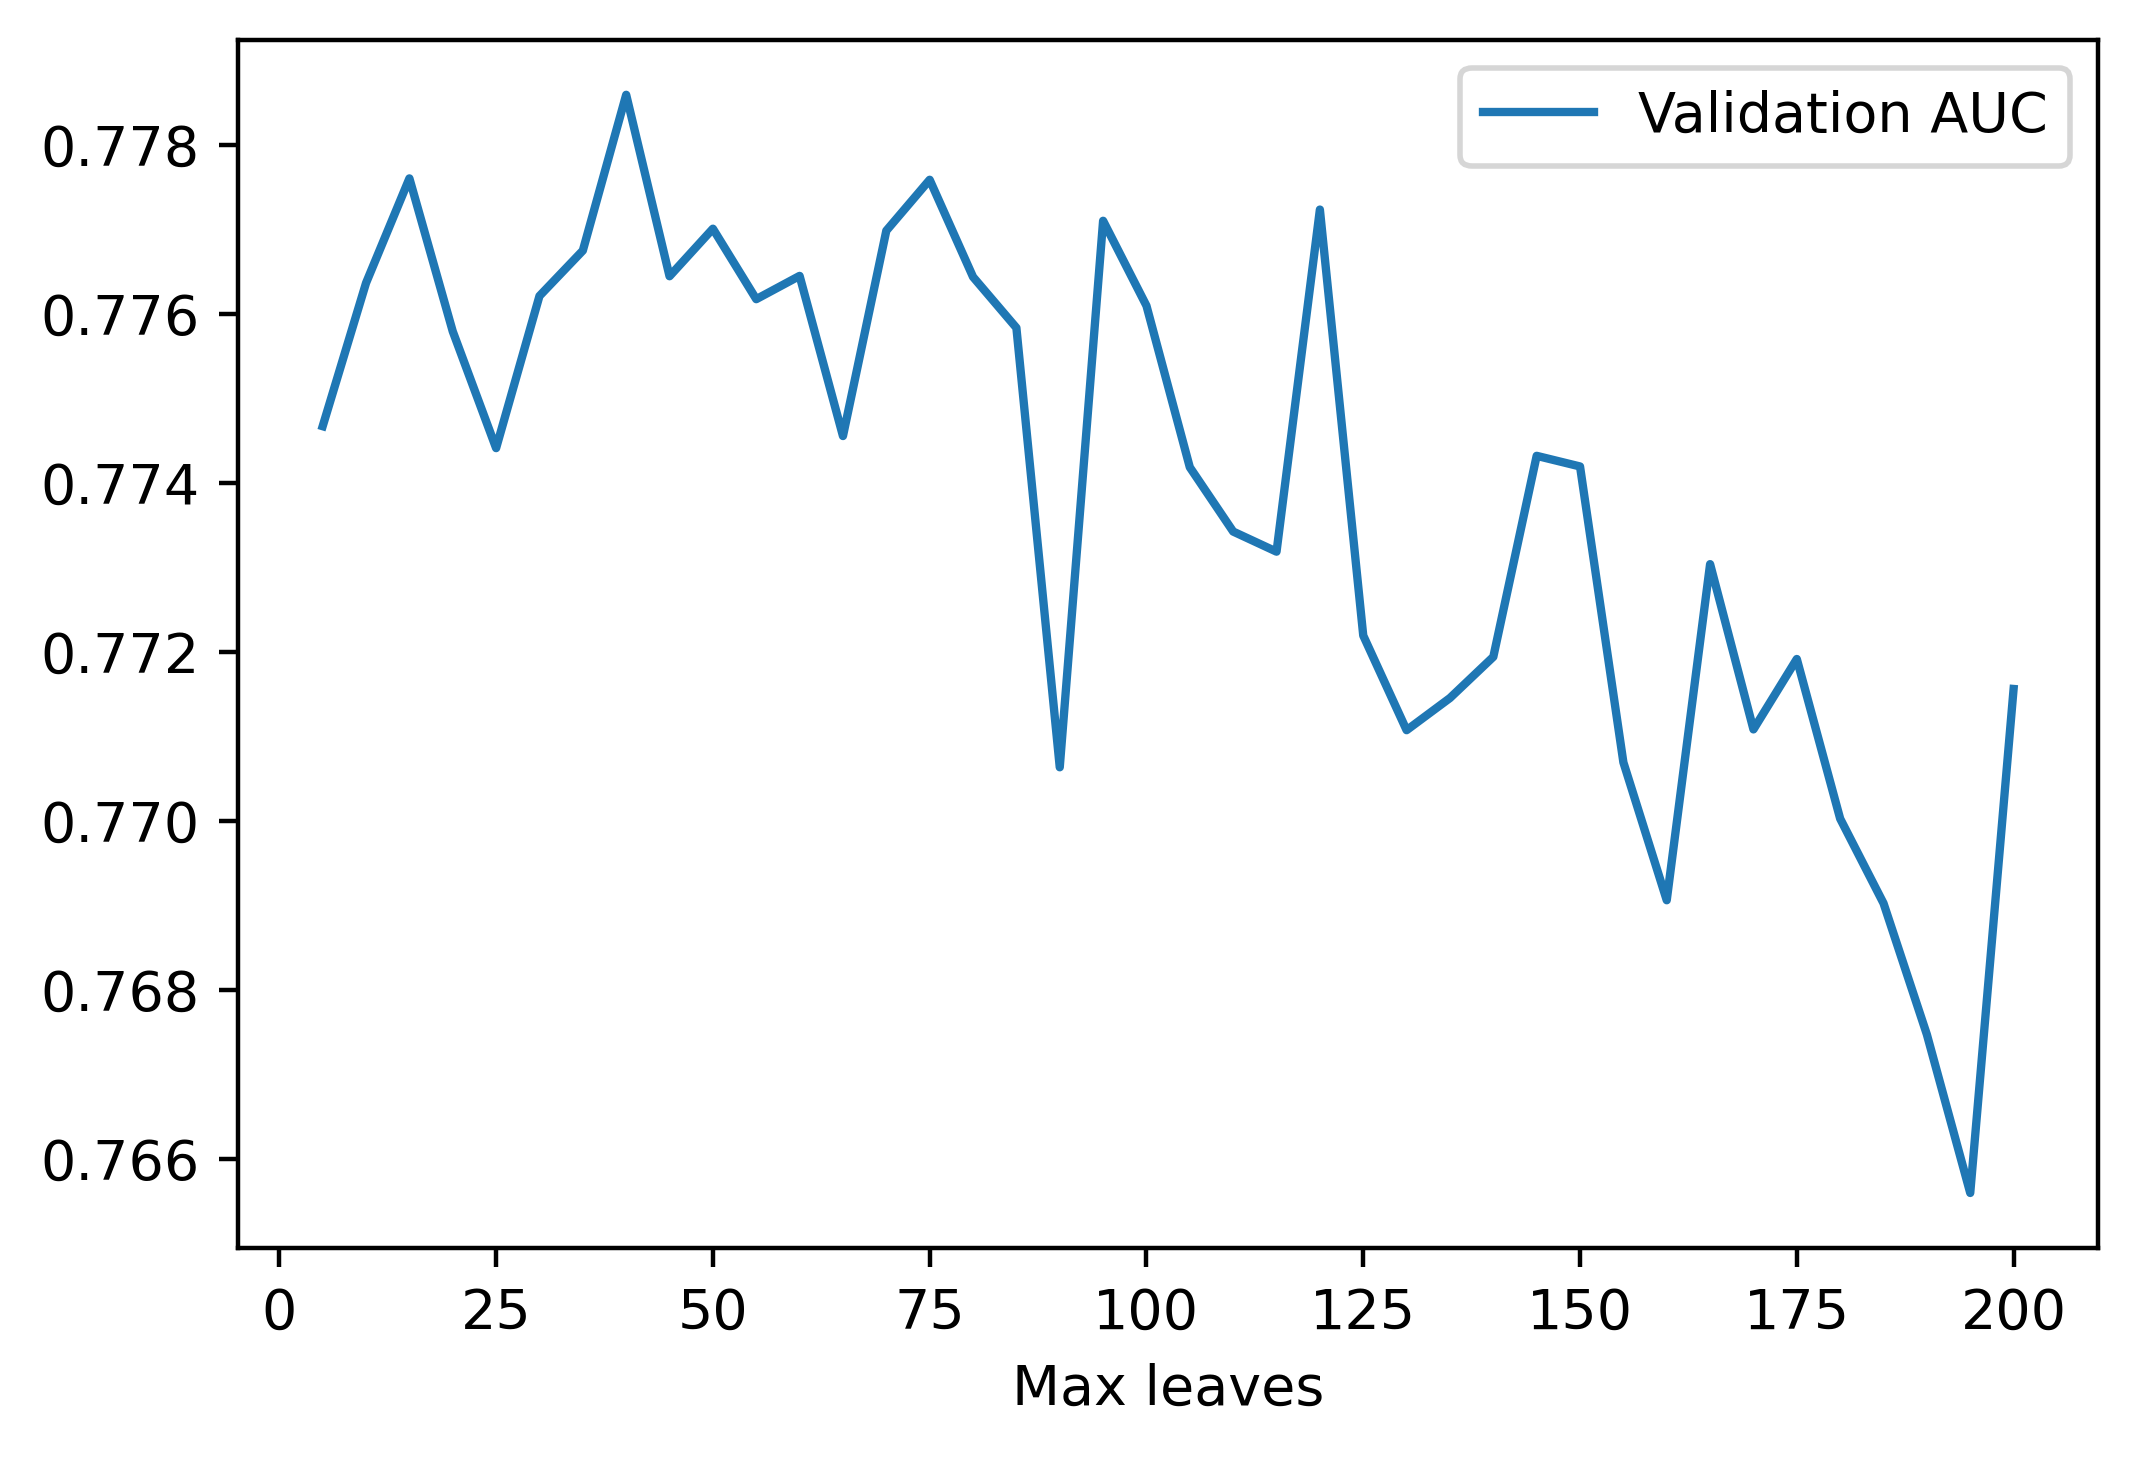

In [79]:
mpl.rcParams['figure.dpi'] = 400
max_leaves_df_2.set_index('Max leaves').plot()

In [80]:
max_auc_2 = max_leaves_df_2['Validation AUC'].max()
max_auc_2
# 0.7785918508068121 (learning rate 0.1)
# 0.7783846497029288 (learning rate 0.05)

0.7785918508068121

In [81]:
max_ix_2 = max_leaves_df_2['Validation AUC'] == max_auc_2
max_leaves_df_2[max_ix_2]

,Max leaves,Validation AUC
7,40,0.778592


Retrain with optimal hyperparameter.

In [82]:
xgb_model_4.set_params(**{'max_leaves':40})
xgb_model_4.fit(X_train_2, y_train_2, eval_set=eval_set_2,
              eval_metric='auc',
              verbose=False, early_stopping_rounds=30)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=0, max_leaves=40, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

In [83]:
# X_val_2

In [84]:
X_val_2_df = pd.DataFrame(data=X_val_2, columns=features_response[:-1])

In [85]:
# X_val_2_df.head(40)

SHAP summary

In [86]:
%time explainer_2 = shap.explainers.Tree(xgb_model_4, data=X_val_2_df)

CPU times: user 176 ms, sys: 10.6 ms, total: 187 ms
Wall time: 173 ms


In [87]:
%time shap_values_2 = explainer_2(X_val_2_df)

CPU times: user 9.79 s, sys: 42.8 ms, total: 9.83 s
Wall time: 9.81 s


In [88]:
shap_values_2.values.shape

(4750, 17)

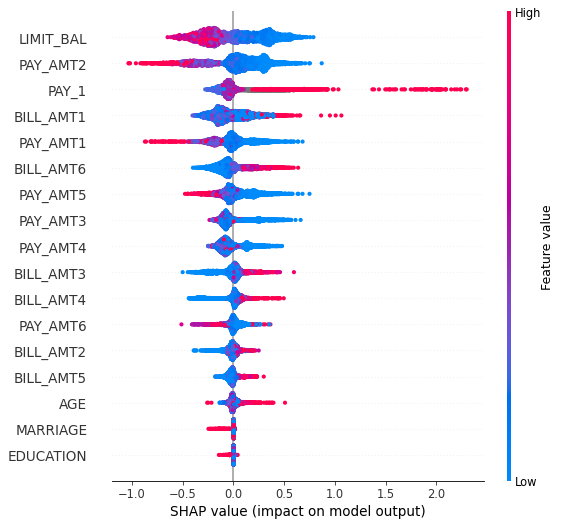

CPU times: user 1.1 s, sys: 36.9 ms, total: 1.14 s
Wall time: 1.17 s


In [89]:
%%time
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values_2.values, X_val_2_df)

Use the feature of SHAP that looks for the strongest interaction effect.

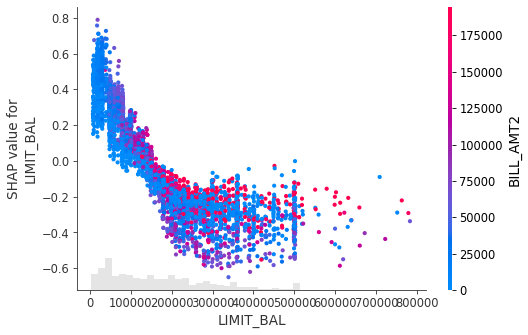

In [90]:
shap.plots.scatter(shap_values_2[:,'LIMIT_BAL'],
                   color=shap_values_2)

Save the features and response name list, training and testing sets, and trained model to refer to and analyze later.

In [91]:
# with open('../../Data/xgb_model_w_data.pkl', 'wb') as f:
#     pickle.dump([features_response,
#                  X_train_all, y_train_all,
#                  X_test_all, y_test_all,
#                  xgb_model_4], f)